# Jump type classifier training
Following the code, you will be able to train jump type classifier and convert it to Arduino compatible format

#### Load and Resample Dataset

The code below loads the data from Google Drive and resamples the data with 33 Hz. We used left hand and right hand data for training and only used left hand data which was clearer for test.

In [1]:
# Google drive path
jump_train= "1WC6G0WINg5fvd-rwsjCyZMK8pcLkLmok"
jump_r_train= "1YGRsabtyqsTP0txUZmQ5Tv-X8jsk_lpr"
jump_test= "1hK0m1_pR_KB_sUHgd5wesRg-zX-Co0Ti"

x_train= "1N8xw0GY9s47LC5AP4tS6Lq9gqmurK_n2"
x_r= "1u4HjsO6iEIj6Alv3RuAxAoDszwWzoFfu"
x_test= "1an_P0nNPkkdpeugLVzVo_vqfnZBKNEF-"

back_train= "1Vs232s_qL9Np-GGP4b45BG_nT-OOkvNb"
back_r_train= "1-hrXhDSOnoUJtjD4ELnXGe3Xlh19y4bD"
back_test= "1-gfbdrNUxz0QENcqEo9m_Itdr9L3cKA5"

double_train= "17E86CiMX6nIkGV9wYhO5YG6S5dkUhYF6"
double_r_0= "1bLd7vdM8vwtdPtoXFaJdmBRsOdUsn_V5"
double_r_1= "1pUzhf8lUjZigaDHZC6nn37JqZfy27_mi"
double_test= "1XablBdqIJUMf5gQJR0RTeQkLH93LVXj5"

In [2]:
from urllib.request import urlopen
import numpy as np
import pandas as pd

# use this one for reading from google drive
load_data = lambda x: pd.read_csv(
    urlopen(f'https://drive.google.com/uc?export=download&id={x}')
).assign(
    timestamp=lambda x: pd.TimedeltaIndex(x['timestamp'], unit='ms')
).set_index(
    'timestamp'
).resample(
    '30ms'
).nearest().values

# this one for downloaded files
# load_data = lambda x: pd.read_csv(
#    f"{x}.csv"
# ).assign(
#     timestamp=lambda x: pd.TimedeltaIndex(x['timestamp'], unit='ms')
# ).set_index(
#     'timestamp'
# ).resample(
#     '30ms'
# ).nearest().values

# train data include left hand and right hand case, test data only include left hand case
NORMAL_DATA = np.append(load_data(jump_train), load_data(jump_r_train), axis=0)
NORMAL_DATA_TEST = load_data(jump_test)
X_DATA = np.append(load_data(x_train), load_data(x_r), axis=0)
X_DATA_TEST = load_data(x_test)
BACK_DATA = np.append(load_data(back_train), load_data(back_r_train), axis=0)
BACK_DATA_TEST = load_data(back_test)
DOUBLE_DATA = np.append(np.append(load_data(double_train), load_data(double_r_0), axis=0), load_data(double_r_1), axis=0)
DOUBLE_DATA_TEST = load_data(double_test)

[(0, 0, 1), (0, 0.5, 0), (1, 0, 0), (0, 0.75, 0.75), (0.75, 0, 0.75), (0.75, 0.75, 0), (0, 0, 0), (1, 1, 1)]


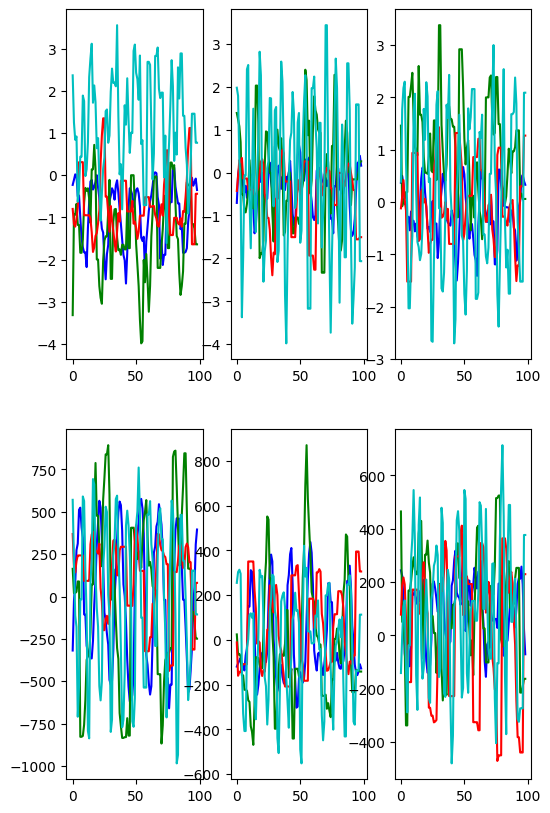

In [3]:
# visualize the given data, can be used to check data quality
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
plt.figure(figsize=(6,10))
color = list(mcolors.BASE_COLORS.values())
print(color)
for j, data in enumerate([NORMAL_DATA,X_DATA, BACK_DATA, DOUBLE_DATA]): # X_DATA, BACK_DATA, DOUBLE_DATA
  a = random.randint(0, 10)
  for i in range(6):

    plt.subplot(2, 3, i+1)
    plt.plot(data[a*33:33*(a+3), i], color=color[j])
plt.show()

In [6]:
# based on the minimum length of each class data, set the data length
import math
HZ = 33
train_size = 3000
for data in [NORMAL_DATA, X_DATA, BACK_DATA, DOUBLE_DATA]:
  train_size = min(train_size, math.floor(data.shape[0]/HZ-2))

test_size = 3000
for data in [NORMAL_DATA_TEST, X_DATA_TEST, BACK_DATA_TEST, DOUBLE_DATA_TEST]:
  test_size = min(test_size, math.floor(data.shape[0]/HZ-2))

#### Split Data

Here, we will use data while maintaing same size of each jump. If you want you can add some feature extraction here. However, we found out that using navie data as below is better.
 $$[acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z]$$
Our window size is 2 seconds with 75% overlap due to small dataset size.

In [7]:
import numpy as np
import random

random.seed(1004)

HZ = 33
X, y = [], []

for l, d in zip([0, 1, 2, 3], [NORMAL_DATA, X_DATA, BACK_DATA, DOUBLE_DATA]): # Label: 0 - Normal, 1 - X, 2 - Back, 3 - Double
    count = 0
    for i in np.arange(0, train_size, 0.25):
        s, e = int(i * HZ), int((i + 2) * HZ)
        X.append(d[s:e, :])
        count += 1
    y.append(np.repeat(l, count))

X_train, y_train = np.asarray(X), np.concatenate(y, axis=0)

X, y = [], []
for l, d in zip([0, 1, 2, 3], [NORMAL_DATA_TEST, X_DATA_TEST, BACK_DATA_TEST, DOUBLE_DATA_TEST]): # Label: 0 - Normal, 1 - X, 2 - Back, 3 - Double
    count = 0
    for i in np.arange(0, test_size, 0.25):
        s, e = int(i * HZ), int((i + 2) * HZ)
        X.append(d[s:e, :])
        count += 1
    y.append(np.repeat(l, count))

X_test, y_test = np.asarray(X), np.concatenate(y, axis=0)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1264, 66, 6)
X_test: (208, 66, 6)
y_train: (1264,)
y_test: (208,)


#### Model Definition
Define the model, using tensorflow keras.

About the model structure, since the model processes time-series data, we used 1D conv first to get features along time axis. Then, we apply max pooling to avoid overfitting and train it to learn more generalizable mechanism. Them, we apply batch normalization and flatten the data. Finally, we apply simple fully connected layer to extract probability of each class with softnax.

---
```
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 conv1d_46 (Conv1D)          (None, 66, 4)             196

 max_pooling1d_26 (MaxPoolin  (None, 16, 4)            0
 g1D)

 batch_normalization_48 (Bat  (None, 16, 4)            16
 chNormalization)

 activation_48 (Activation)  (None, 16, 4)             0

 flatten_38 (Flatten)        (None, 64)                0

 dropout_38 (Dropout)        (None, 64)                0

 dense_62 (Dense)            (None, 4)                 260

=================================================================
Total params: 472
Trainable params: 464
Non-trainable params: 8
_________________________________________________________________
```

In [9]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(66, 6)),
    keras.layers.Conv1D(
        filters=4, kernel_size=8, strides=1,padding = "same",
        kernel_initializer=keras.initializers.HeNormal(seed=1004),
    ),
    keras.layers.MaxPooling1D(
        pool_size=4
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Flatten(),
    keras.layers.Dropout(
        rate = .5,
    ),
    keras.layers.Dense(
        units = 4, # Normal jump, Backward jump, Cross jump, Double jump
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=1004),
    )
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 66, 4)             196       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 4)            0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 16, 4)            16        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16, 4)             0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)               

#### Model Training
Now compile and train the defined model.

As our model classifies the type of jump, we will use a sparse categorical crossentropy as the loss function.

In [10]:
from tensorflow import keras

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=85,
)

Epoch 1/85
40/40 [==============================] - 2s 12ms/step - loss: 1.8554 - sparse_categorical_accuracy: 0.2524 - val_loss: 2.2345 - val_sparse_categorical_accuracy: 0.1490
Epoch 2/85
40/40 [==============================] - 0s 5ms/step - loss: 1.6499 - sparse_categorical_accuracy: 0.2603 - val_loss: 1.6505 - val_sparse_categorical_accuracy: 0.2404
Epoch 3/85
40/40 [==============================] - 0s 4ms/step - loss: 1.4887 - sparse_categorical_accuracy: 0.3275 - val_loss: 1.4125 - val_sparse_categorical_accuracy: 0.3269
Epoch 4/85
40/40 [==============================] - 0s 4ms/step - loss: 1.3487 - sparse_categorical_accuracy: 0.3877 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4038
Epoch 5/85
40/40 [==============================] - 0s 4ms/step - loss: 1.2371 - sparse_categorical_accuracy: 0.4153 - val_loss: 1.1115 - val_sparse_categorical_accuracy: 0.4519
Epoch 6/85
40/40 [==============================] - 0s 4ms/step - loss: 1.1306 - sparse_categorical_accuracy:

#### Evaluation
Now using the test data whihc was collected in the differnt environment, we can evaluate our model in more realistic matter. It is important to use data from different environment to get more realistic performance.

7/7 [==============================] - 0s 3ms/step
Accuracy: 87.98 %.


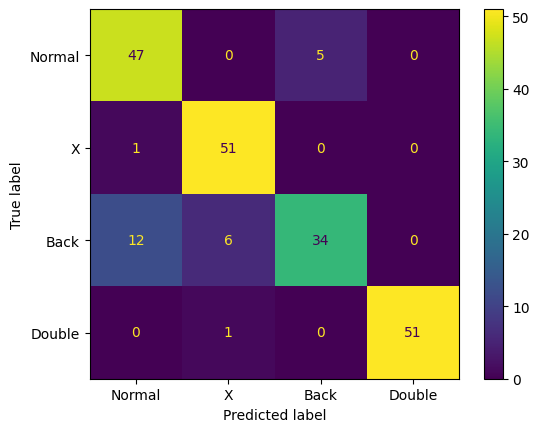

In [11]:
# check the accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc * 100:.2f} %.')
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "X", "Back", "Double"])
disp.plot()
plt.show()

### Model Deploy
You need to convert the keras model into tflite model. In our case, we do not use quantized model as the model is already small and quantization introduce some performance degradation. However, you can try to use quantized model.

In [12]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.isdir(MODELS_DIR):
  os.mkdir(MODELS_DIR)

MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'

In [13]:
import tensorflow as tf
tf.random.set_seed(1)

# convert the model to the TensorFlow Lite format without quantization, used version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  # Set the data shape properly, the range value should be smaller than
  for i in range(600):
    yield [X_train[i].reshape(1, 66, 6).astype(np.float32)]

# et the optimization flag
# you have to specify the supporte_ops
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# provide a representative dataset to ensure we quantize correctly
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


5728

In [14]:
# check the model size
import sys, os
def format_size(variable):
    size_in_bytes = sys.getsizeof(variable)
    units = ["B", "KB"]
    unit_index = 0
    while size_in_bytes >= 1024 and unit_index < len(units) - 1:
        size_in_bytes /= 1024.0
        unit_index += 1
    return "{:.2f} {}".format(size_in_bytes, units[unit_index])

print("Original model is {}".format(format_size(model_no_quant_tflite)))
print("Quantized model is {}".format(format_size(model_tflite)))

Original model is 5.98 KB
Quantized model is 5.63 KB


In [15]:
# check accuracy of converted model
model_new = tf.lite.Interpreter(MODEL_NO_QUANT_TFLITE)

# allocate memory for the model
model_new.allocate_tensors()

# get the input and output tensors so we can feed in values and get the results
# as our data is in 2d shape we used input_index instead
input_index = model_new.get_input_details()[0]["index"]
model_output = model_new.tensor(model_new.get_output_details()[0]["index"])

# create arrays to store the results
model_predictions = np.empty(shape=(y_test.shape[0], 4))

x_test = X_test.astype(np.float32)

# Run each model's interpreter for each value and store the results in arrays
for i in range(X_test.shape[0]):
  # set the tensor
  model_new.set_tensor(input_index, np.expand_dims(x_test[i], 0))
  model_new.invoke()
  model_predictions[i] = model_output()[0]

y_pred_quant = np.argmax(model_predictions, axis=1)
acc = accuracy_score(y_test, y_pred_quant)
print(acc)

0.8798076923076923


In [16]:
# conver model into cc for Arduino
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,012 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,

Using the below code, you can get what you need for `MicroMutableOpResolver`.
May need more operation especially "AddQuantize" for "AddDeQuantize" (In my case, it was additionally necessary).
The model is for newer tensorflow ([github](https://github.com/tensorflow/tflite-micro-arduino-examples)), not our libray.

In [17]:
# from https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/tools/gen_micro_mutable_op_resolver
# resolve library issue

from tensorflow.lite.tools import visualize as visualize
import os
import re


def ParseString(word):
  word = word.replace('TFLite', '')

  word_split = re.split('_|-', word)
  formated_op_string = ''
  for part in word_split:
    if len(part) > 1:
      if part[0].isalpha():
        formated_op_string += part[0].upper() + part[1:].lower()
      else:
        formated_op_string += part.upper()
    else:
      formated_op_string += part.upper()

  # Edge case for AddUnidirectionalSequenceLSTM().
  formated_op_string = formated_op_string.replace('Lstm', 'LSTM')

  return 'Add' + formated_op_string

def GetModelOperatorsAndActivation(model_path):
  custom_op_found = False
  operators_and_activations = set()

  with open(model_path, 'rb') as f:
    data_bytes = bytearray(f.read())

  data = visualize.CreateDictFromFlatbuffer(data_bytes)

  for op_code in data["operator_codes"]:
    if op_code['custom_code'] is None:
      op_code["builtin_code"] = max(op_code["builtin_code"],
                                    op_code["deprecated_builtin_code"])
    else:
      custom_op_found = True
      operators_and_activations.add(
          visualize.NameListToString(op_code['custom_code']))

  for op_code in data["operator_codes"]:
    if custom_op_found and visualize.BuiltinCodeToName(
        op_code['builtin_code']) == "CUSTOM":
      continue

    operators_and_activations.add(
        visualize.BuiltinCodeToName(op_code['builtin_code']))

  return operators_and_activations

def main():
  full_model_path = MODEL_NO_QUANT_TFLITE
  operators = GetModelOperatorsAndActivation(full_model_path)
  parsed_operator_list = []
  for op in sorted(list(operators)):
    parsed_operator_list.append(ParseString(op))
  print(parsed_operator_list)
  print(len(parsed_operator_list))

main()

['AddAdd', 'AddConv2D', 'AddExpandDims', 'AddFullyConnected', 'AddMaxPool2D', 'AddMul', 'AddReshape', 'AddSoftmax']
8
